In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score

# 데이터 로드
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target)


In [3]:
#0.63정도까지 MSE 낮췄는데 혹시 좀 더 낮추신 분들
#MSE 0.6099117178029878
#MSE 0.5384120362811067
#MSE 0.507

#학습 데이터셋 테스트로 분리
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [5]:
#Lienar Regression
#모든 피처를 다 1차로 사용
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train) #선형회귀 학습
y_pred_linear = linear_reg.predict(X_test)#예측값 출력
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Linear Regression MSE :{mse_linear:.4f}')

Linear Regression MSE :0.5290


In [ ]:
##y값이 근거되는 것
##y값이라는 것을 가지고 파생변수나, 전처리의 인사이트의 기준이 되는 것

In [9]:
## y값의 특성에 따라 피처들을 좀 살펴볼 예정 
## 전체 분포를 한 번 볼 필요가 있다. 데이터셋이 분포가 어떤지?
## 시각화 하는 histplot 함수 만들기
def plot_distribution(df, cols, n_cols=3):
    n_rows = (len(cols)+n_cols-1)//n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,4*n_rows))
    for i, col in enumerate(cols):
        row, col_idx = divmod(i, n_cols)
        sns.histplot(df[col], kde=True, ax =axes[row, col_idx])
        axes[row, col_idx].set_title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


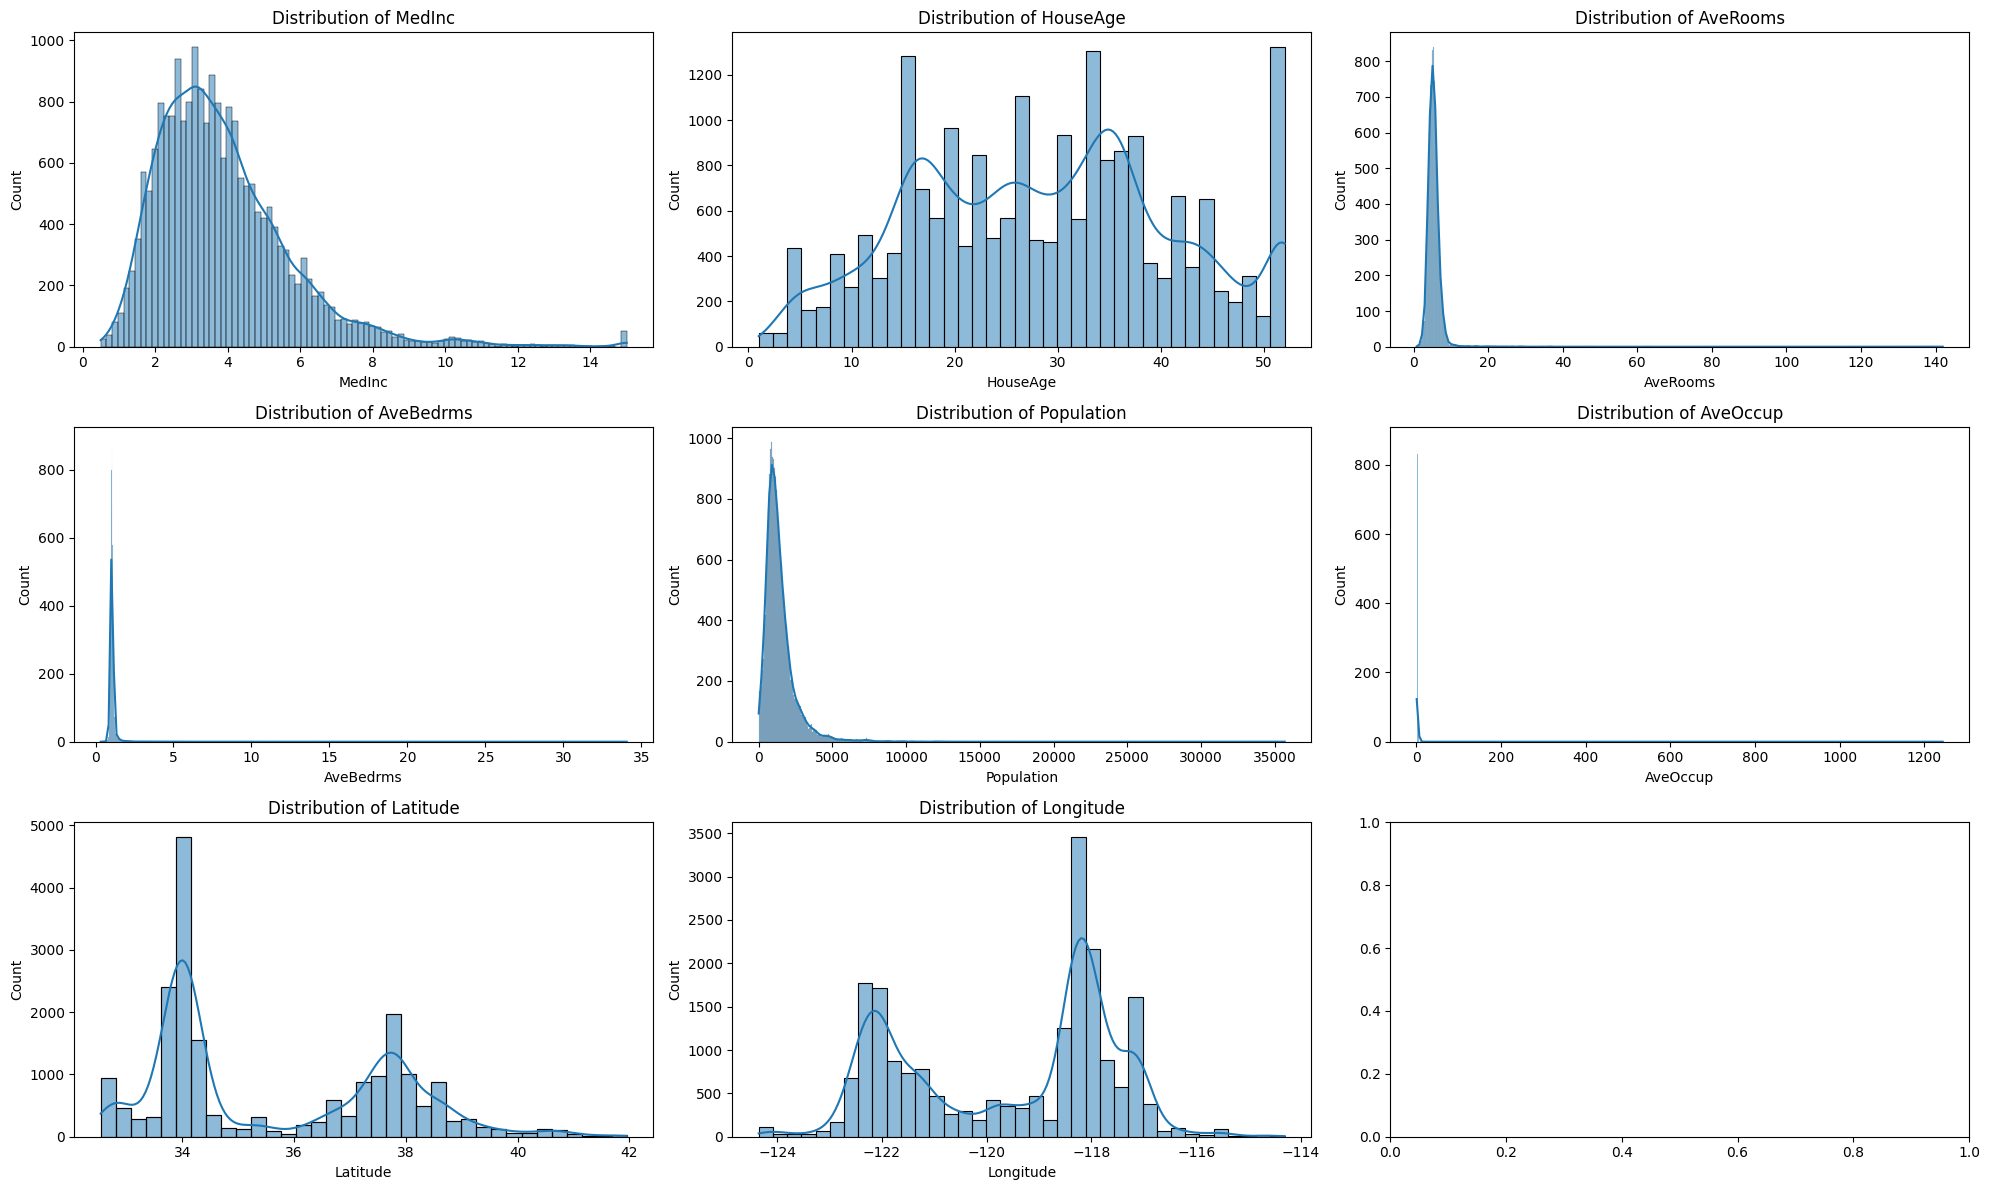

In [12]:
plot_distribution(X, X.columns.tolist())

- 위도,경도
- X값들의 분포를 일단 확인해야 한다. 
- 위도, 경도 어떤 두 그룹의 형태로 좀 보여지는 것 

- 1. 데이터의 분포를 정규분포화로 변환하면 성능이 조금은 좋아질 것이다. 
    - 정규분포를 가정한 통계적인 분석들은 실제 분포자체가 정규분포라는 가정이 들어가기 때문에, 정규분포로 만들어 주면 성능이 좀 더 좋아진다.
- 2. 위도 경도
    - 집값이 높은 곳과 낮은 곳의 어떤 경계나 차이가 존재하지 않을까?
        - 양봉분포가 보이니 이 부분을 좀더 확인해 보면 좋겠다.

In [14]:
from scipy.stats import skew, kurtosis
# 각 변수의 왜도와 첨도 계산
skewness = X.apply(skew).rename('Skewness')
kurt = X.apply(kurtosis).rename('Kurtosis')
stats = pd.concat([skewness,kurt], axis=1)
print(stats)

             Skewness      Kurtosis
MedInc       1.646537      4.951034
HouseAge     0.060326     -0.800726
AveRooms    20.696365    879.139966
AveBedrms   31.314680   1636.315218
Population   4.935500     73.535009
AveOccup    97.632465  10648.430334
Latitude     0.465919     -1.117780
Longitude   -0.297780     -1.330121


In [21]:
# 데이터의 정규분포 변환으로 성능이 좋아지는지 1차 가설 확인
# power transformer, Quantitle transformer
# Box-cox, Yeo-Johnson, Quantitle transformer

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

#Box-Cox 변환
boxcox_transformer =PowerTransformer(method='box-cox')
X_boxcox=X.copy()
#위도, 경도는 제외하고 나머지 변수는 box-cox변환

for col in X.columns:
    if col not in ['Latitude', 'Longitude'] and (X[col]>0).all():
        X_boxcox[col]=boxcox_transformer.fit_transform(X[[col]]) #box_cox는 양수만 가능
        
#Yeo-Johnson 변환( 음수데이터도 가능 )
yeojohnson_transformer =PowerTransformer(method='yeo-johnson')
X_yeojohnson=X.copy()
#위도, 경도는 제외하고 나머지 변수는 Yeo-Johnson변환
for col in X.columns:
    if col not in ['Latitude', 'Longitude']:
        X_yeojohnson[col]=yeojohnson_transformer.fit_transform(X[[col]]) #양수 음수 모두 가능

        
#QuantileTransformer
quantitle_transformer = QuantileTransformer(output_distribution='normal')
X_quantitle=X.copy()

#위도 경도 제외하고 나머지 변수 quantitle
for col in X.columns:
    if col not in ['Latitude', 'Longitude']:
        X_quantitle[col]=quantitle_transformer.fit_transform(X[[col]]) #양수 음수 모두 가능


In [25]:
#모델에 대한 성능 비교
def evaluate_model(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)
    model = LinearRegression()
    model.fit(X_train, y_train) #선형회귀 학습
    y_pred = model.predict(X_test)#예측값 출력
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [28]:
#원본데이터
mse_original=evaluate_model(X,y)
print(f'mse_original : {mse_original:.4f}')

#Box-Cox
mse_X_boxcox=evaluate_model(X_boxcox,y)
print(f'mse_original : {mse_X_boxcox:.4f}')

#yeojohnson
mse_X_yeojohnson=evaluate_model(X_yeojohnson,y)
print(f'mse_original : {mse_X_yeojohnson:.4f}')

#quantitle
mse_X_quantitle=evaluate_model(X_quantitle,y)
print(f'mse_original : {mse_X_quantitle:.4f}')

mse_original : 0.5290
mse_original : 0.5097
mse_original : 0.5100
mse_original : 0.5134


- 첫 번째 가설인 정규분포로 변환하니깐 확실히 성능이 좀 더 좋아졌다.

In [34]:
y=pd.Series(california.target, name='y')
data = pd.concat([X,y], axis=1)

5.00001
0.14999


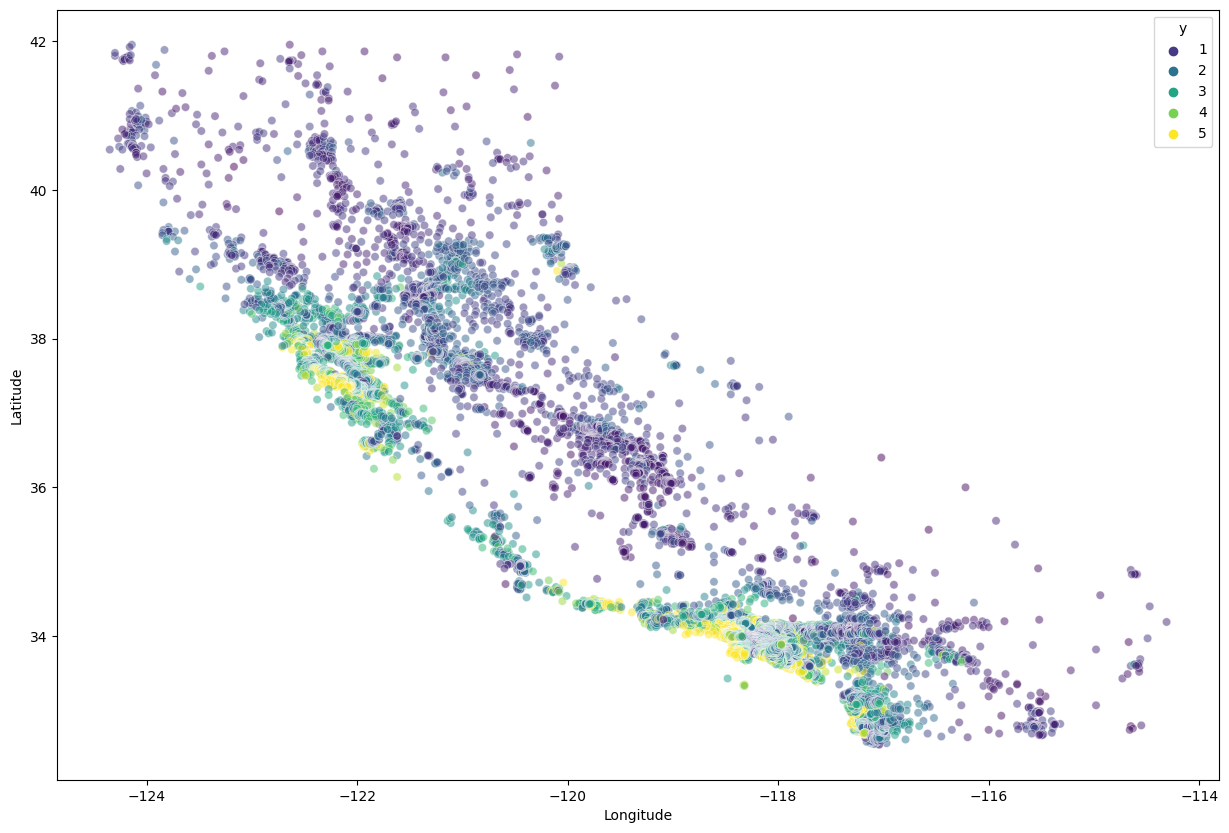

In [38]:
## 2번 째 가설
## 위도,경도에 대한 어떤 인사이트를 어떤 기준으로 봐야할까요?
## y값이 영향을 준다. 

## 시각화를 통한 y값의 분포를 확인하자!

print(np.max(y))
print(np.min(y))

#위도와 경도를 통한 y값 분포

plt.figure(figsize=(15,10))
sns.scatterplot(x='Longitude',y='Latitude',hue='y',data=data, palette='viridis',alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

<Axes: xlabel='y', ylabel='Count'>

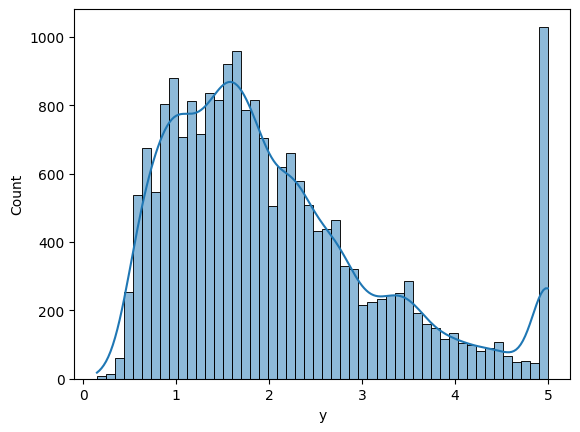

In [39]:
#y값의 분포
#y값의 분포 그래프
sns.histplot(y,bins=50,kde=True)

In [43]:
## 집값을 상위, 하위 중위로 나눠서 분포를 살펴보기
quantitles=y.quantile([0.2,0.8]).values
X['HighValueArea'] =((y>quantitles[1]).astype(int)) #상위 20%인 경우 1, 아니면 0 라벨을 하나 추가한 것 

In [47]:
X['HighValueArea'].value_counts() 

0    16515
1     4125
Name: HighValueArea, dtype: int64

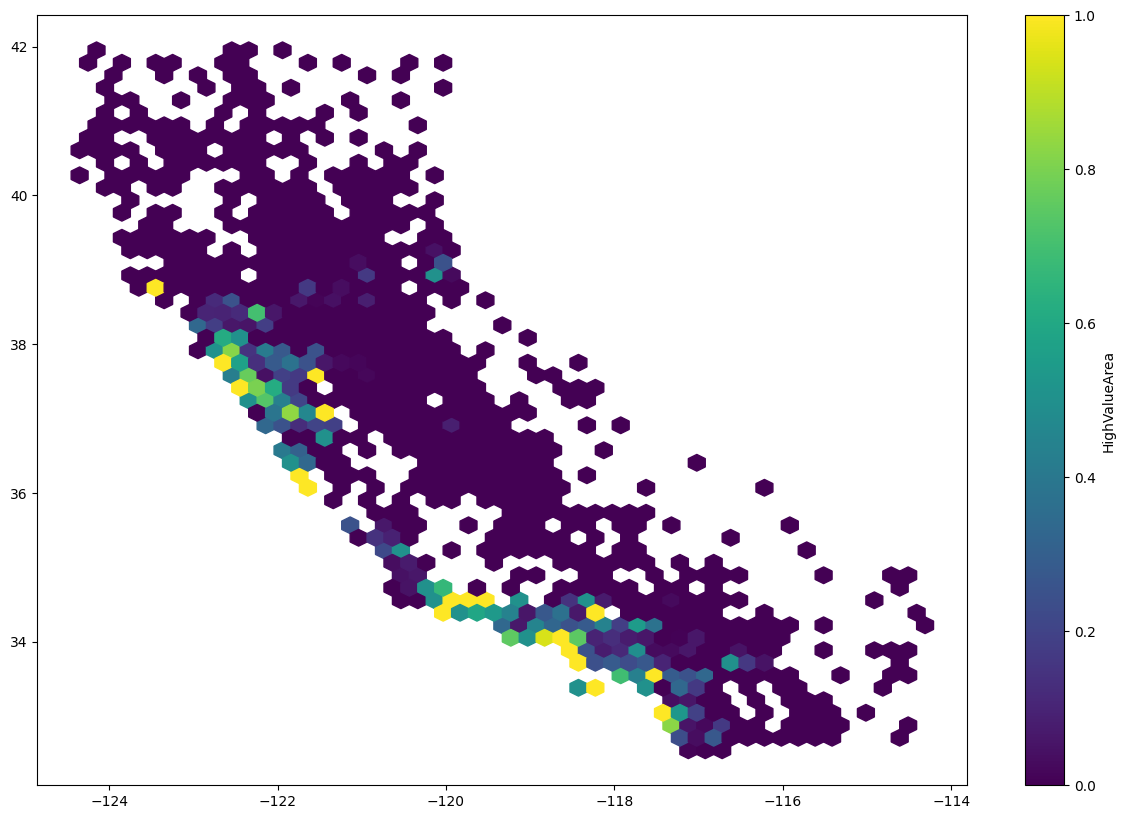

In [49]:
plt.figure(figsize=(15,10))
hb =plt.hexbin(X['Longitude'],X['Latitude'], C=X['HighValueArea'], gridsize=50, cmap='viridis')
cb = plt.colorbar(hb, label='HighValueArea')

### X에 피처가 추가되었으니 다시 한 번 정규분포로 변환하여 가설1, 가설2를 모두 통합하는 성능을 비교해 보자!

In [51]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,HighValueArea
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,1
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,1
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,1
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,1
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,1
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0


In [52]:
#Box-Cox 변환
boxcox_transformer =PowerTransformer(method='box-cox')
X_boxcox=X.copy()
#위도, 경도는 제외하고 나머지 변수는 box-cox변환

for col in X.columns:
    if col not in ['Latitude', 'Longitude','HighValueArea'] and (X[col]>0).all():
        X_boxcox[col]=boxcox_transformer.fit_transform(X[[col]]) #box_cox는 양수만 가능
        
#Yeo-Johnson 변환( 음수데이터도 가능 )
yeojohnson_transformer =PowerTransformer(method='yeo-johnson')
X_yeojohnson=X.copy()
#위도, 경도는 제외하고 나머지 변수는 Yeo-Johnson변환
for col in X.columns:
    if col not in ['Latitude', 'Longitude','HighValueArea']:
        X_yeojohnson[col]=yeojohnson_transformer.fit_transform(X[[col]]) #양수 음수 모두 가능

        
#QuantileTransformer
quantitle_transformer = QuantileTransformer(output_distribution='normal')
X_quantitle=X.copy()

#위도 경도 제외하고 나머지 변수 quantitle
for col in X.columns:
    if col not in ['Latitude', 'Longitude','HighValueArea']:
        X_quantitle[col]=quantitle_transformer.fit_transform(X[[col]]) #양수 음수 모두 가능


- 모든 변수 다 사용하고 + 위도, 경도에 따른 파생변수  추가 + 파생변수와 위도 경도를 제외한 나머지는 정규분포화 변환
- 최종 성능평가에 대한 전처리 방향

In [55]:
#원본데이터
mse_original=evaluate_model(X,y)
print(f'mse_original : {mse_original:.4f}')

#Box-Cox
mse_X_boxcox=evaluate_model(X_boxcox,y)
print(f'mse_original : {mse_X_boxcox:.4f}')

#yeojohnson
mse_X_yeojohnson=evaluate_model(X_yeojohnson,y)
print(f'mse_original : {mse_X_yeojohnson:.4f}')

#quantitle
mse_X_quantitle=evaluate_model(X_quantitle,y)
print(f'mse_original : {mse_X_quantitle:.4f}')

mse_original : 0.2494
mse_original : 0.2330
mse_original : 0.2328
mse_original : 0.2334


- 전 시간에는 0.63
- Linear Regression MSE :0.5290
- 이번에는 추가한 전처리로 yeojohnson MSE 0.2328 로 나왔다.

In [57]:
## 교차검증까지 진행해서 성능에 대한 과적합을 피해서 진행해야 한다.

def cross_val_evaluate_model(X,y):
    model = LinearRegression()
    mse_score = make_scorer(mean_squared_error, greater_is_better=False)
    cv_scores = cross_val_score(model, X,y, cv=5, scoring=mse_score)
    return -np.mean(cv_scores)

#원본데이터
mse_original=cross_val_evaluate_model(X,y)
print(f'mse_original : {mse_original:.4f}')

#Box-Cox
mse_X_boxcox=cross_val_evaluate_model(X_boxcox,y)
print(f'mse_original : {mse_X_boxcox:.4f}')

#yeojohnson
mse_X_yeojohnson=cross_val_evaluate_model(X_yeojohnson,y)
print(f'mse_original : {mse_X_yeojohnson:.4f}')

#quantitle
mse_X_quantitle=cross_val_evaluate_model(X_quantitle,y)
print(f'mse_original : {mse_X_quantitle:.4f}')

mse_original : 0.2600
mse_original : 0.2408
mse_original : 0.2403
mse_original : 0.2439


- 결론적으로는 0.7에서 시작하여 -> 0.24정도까지 (교차검증하여) 줄인 것

In [59]:
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,y
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
